In [1]:
import cv2
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import LeakyReLU

from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.models import Input
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.compat.v1.reset_default_graph()

IMG_SIZE = 48
#LR = 1e-3
#MODEL_NAME = 'Classifier-{}-{}.model'.format(LR, '6conv-basic')

In [2]:
#Incorporar imagenes
def read_images(dirname):
    imgpath = dirname + os.sep
    images = []
    directories = []
    dircount = []
    prevRoot=''
    cant=0
    print("incorporando imagenes de ",imgpath)

    for root, dirnames, filenames in os.walk(imgpath):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                cant+=1
                filepath = os.path.join(root, filename)
                # image = plt.imread(filepath)
                image = cv2.imread(filepath)
                plt.imshow(image)
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                images.append(image)
                if prevRoot !=root:
                    prevRoot=root
                    directories.append(root)
                    dircount.append(cant)
                    cant=0
    dircount.append(cant)

    dircount = dircount[1:]
    dircount[0]=dircount[0]+1
    print('Directorios leidos:',len(directories))
    print("Imagenes en cada directorio", dircount)
    print('Suma Total de imagenes en subdirs:',sum(dircount))
    
    tipos=[]
    indice=0
    for directorio in directories:
        name = directorio.split(os.sep)
        print(indice , name[len(name)-1])
        tipos.append(name[len(name)-1])
        indice=indice+1

    labels=[]
    indice=0
    for cantidad in dircount:
        for i in range(cantidad):
            labels.append(tipos[indice])
        indice=indice+1

    X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
    y = np.array(labels)
    return X, y

incorporando imagenes de  C:\Users\esteb\Documents\Maestria UIDE\Tratamiento de datos\Examen\CarneDataset/train\
Directorios leidos: 7
Imagenes en cada directorio [63, 213, 105, 949, 37, 204, 62]
Suma Total de imagenes en subdirs: 1633
0 CLASS_02
1 CLASS_03
2 CLASS_04
3 CLASS_05
4 CLASS_06
5 CLASS_07
6 CLASS_08
incorporando imagenes de  C:\Users\esteb\Documents\Maestria UIDE\Tratamiento de datos\Examen\CarneDataset/test\
Directorios leidos: 8
Imagenes en cada directorio [2, 48, 97, 45, 459, 19, 114, 26]
Suma Total de imagenes en subdirs: 810
0 CLASS_01
1 CLASS_02
2 CLASS_03
3 CLASS_04
4 CLASS_05
5 CLASS_06
6 CLASS_07
7 CLASS_08


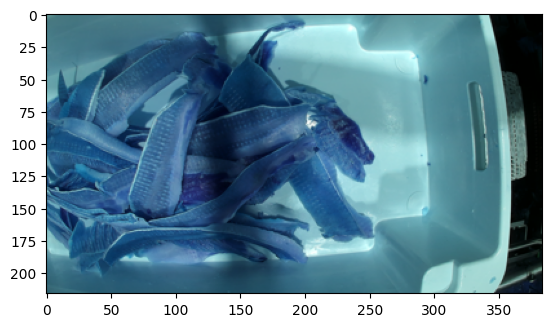

In [3]:
#Creamos Entrenamiento y Test
X_train,y_train = read_images(os.path.join(os.getcwd(), 'CarneDataset/train'))
X_test,y_test = read_images(os.path.join(os.getcwd(), 'CarneDataset/test'))
#X_train = 'CarneDataset/train'
#X_test= 'CarneDataset/test'

In [4]:
#Preprocesamiento
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train = X_train / 255.0
#X_test = X_test / 255.0

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [6]:
#X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [7]:
train_X,valid_X,train_label,valid_label = train_test_split(X_train, train_Y_one_hot, test_size=0.4, random_state=23)

In [8]:
classes_train = np.unique(y_train)
nClasses_train = len(classes_train)

In [9]:
import os
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from sklearn import svm

In [42]:
INIT_LR = 0.0005 # Learning Rate
epochs = 30 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 10 # Cantidad de imágenes que se toman cada vez 
steps = 20
validation = 10

#procesamiento de imagenes
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.1,
                             width_shift_range=0.1,  # Rango de desplazamiento horizontal
                             shear_range=0.1,
                             channel_shift_range=0.1,
                             brightness_range=[0.95, 1.05],
                             horizontal_flip=True,  # Volteo horizontal
                             vertical_flip=False) 
#Modelo
classifier_model = Sequential()
#Capa 1
classifier_model.add(Convolution2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
classifier_model.add(MaxPooling2D((2, 2),padding='same'))
#Capa 2
classifier_model.add(Convolution2D(128, kernel_size=(3, 3),activation='relu',padding='same'))
classifier_model.add(MaxPooling2D((2, 2),padding='same'))
#Capa 3
classifier_model.add(Convolution2D(256, kernel_size=(2, 2),activation='relu',padding='same'))
classifier_model.add(MaxPooling2D((3, 3),padding='same'))
classifier_model.add(LeakyReLU(alpha=0.1))
#classifier_model.add(Dropout(0.6))

#capas de salida
#classifier_model.add(Dropout(0.6))
classifier_model.add(Flatten())
classifier_model.add(Dense(256, activation='relu'))
classifier_model.add(LeakyReLU(alpha=0.1))
classifier_model.add(Dropout(0.6))
classifier_model.add(Dense(nClasses_train, activation='softmax'))
classifier_model.summary()

#classifier_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

optimizer = keras.optimizers.Adam(learning_rate=INIT_LR)
classifier_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

classifier_train = classifier_model.fit(datagen.flow(train_X, train_label, batch_size=batch_size),epochs=epochs,
                                         verbose=1,validation_data=(valid_X, valid_label))
    
#se guarda el modelo
directorio = './modelos/'
if not os.path.exists(directorio):
  os.mkdir(directorio)
classifier_model.save('modelos/model-2.h5')
classifier_model.save_weights('modelos/weights-2.h5')    
    
predicted_classes_result = classifier_model.predict(X_test)

predicted_classes_test=[]
for predicted_image in predicted_classes_result:
    predicted_classes_test.append(predicted_image.tolist().index(max(predicted_image)))
predicted_claspredicted_classes_testses=np.array(predicted_classes_test)


predicted_classes_result = classifier_model.predict(X_train)

predicted_classes_train=[]
for predicted_image in predicted_classes_result:
    predicted_classes_train.append(predicted_image.tolist().index(max(predicted_image)))
predicted_classes_train=np.array(predicted_classes_train)

#Matrices de confusion
print("Test:")
test_matrix = confusion_matrix(y_test, predicted_classes_test)
print(test_matrix)
print("\n")
print("Train:")
train_matrix = confusion_matrix(y_train, predicted_classes_train)
print(train_matrix)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 256)       131328    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 256)       

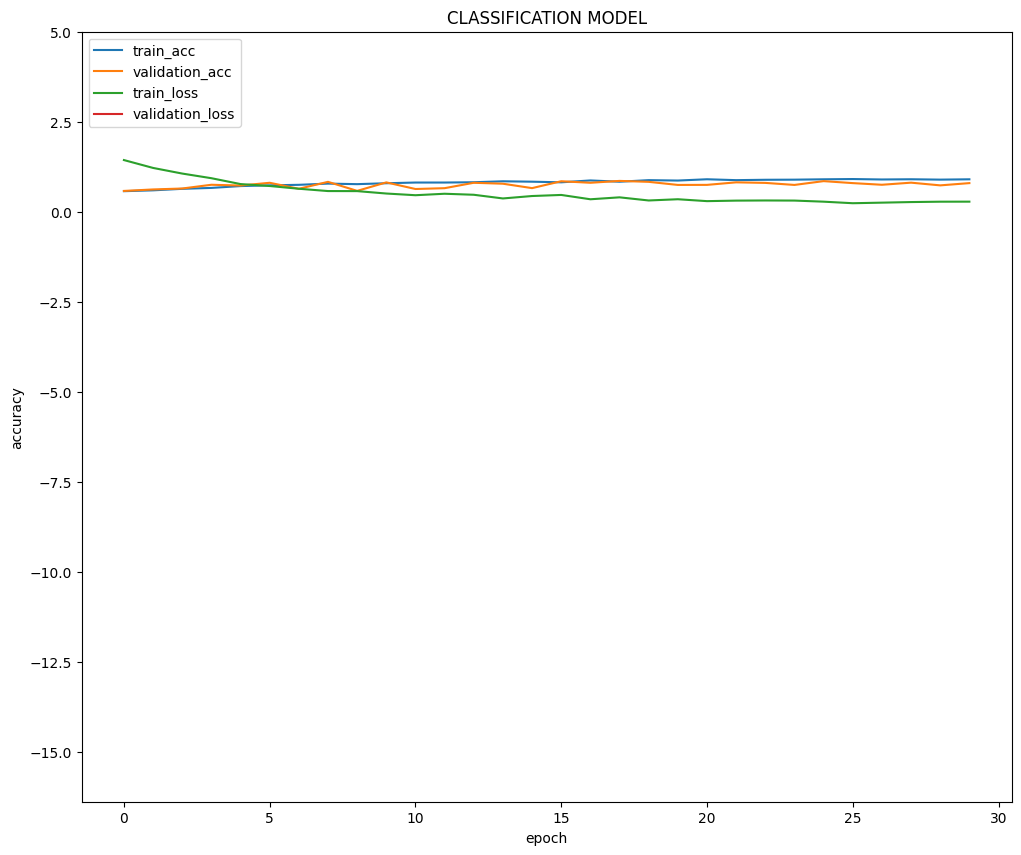

In [75]:
import matplotlib.pyplot as plt

def plot_hist(hist, name):
        """Plots training chart"""
        plt.figure(figsize=[12, 10])
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title(f"{name}")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.ylim(top=5.0)
        plt.legend(["train_acc", "validation_acc","train_loss","validation_loss"], loc="upper left")
        plt.savefig(f'{name}_chart.png')
        plt.show()

plot_hist(classifier_train, name='CLASSIFICATION MODEL')

In [12]:
from mlxtend.plotting import plot_confusion_matrix

TEST MATRIX


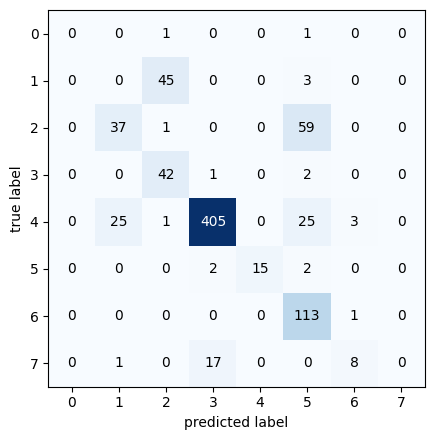

In [76]:
print("TEST MATRIX")
plot_confusion_matrix(test_matrix, figsize=(4.5,4.5), show_normed = False)
plt.tight_layout()

TRAIN MATRIX


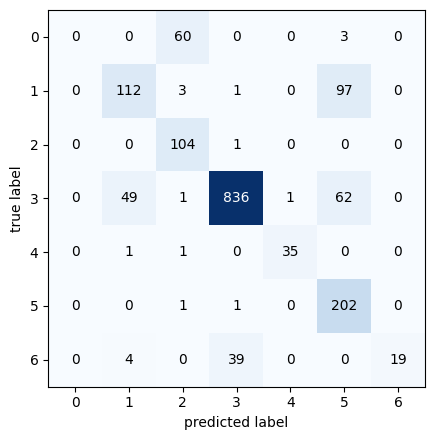

In [45]:
print("TRAIN MATRIX")
plot_confusion_matrix(train_matrix, figsize=(4.5,4.5), show_normed = False)
plt.tight_layout()

In [96]:
precision = classifier_train.history['accuracy']
perdida = classifier_train.history['loss']
precision_test = classifier_train.history['val_accuracy']
perdida_test = classifier_train.history['val_loss']

print(f"Accuracy: {precision[-1]*100:.4f}")
print(f"Loss: {perdida[-1]:.4f}")
print(f"Validation Accuracy: {precision_test[-1]*100:.4f}")
print(f"Validation Loss: {perdida_test[-1]:.4f}")

Accuracy: 90.3984
Loss: 0.2835
Validation Accuracy: 79.8165
Validation Loss: 142.3390


In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [77]:
#cargar el modelo entrenado
modelo = 'modelos/model.h5'
pesos_modelo = 'modelos/weights.h5'
classifier = load_model(modelo) 
classifier.load_weights(pesos_modelo)

81/81 [==============================] - 3s 25ms/step


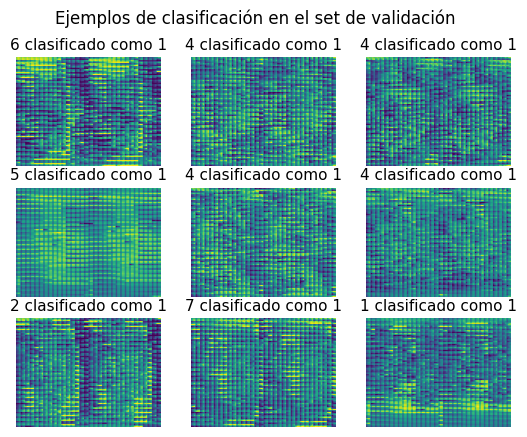

In [82]:
#el mismo procesamiento a las imagenes de test
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             zoom_range=0.2,
                             height_shift_range=0.1,
                             width_shift_range=0.1,  # Rango de desplazamiento horizontal
                             shear_range=0.1,
                             channel_shift_range=0.1,
                             brightness_range=[0.95, 1.05],
                             horizontal_flip=True,  # Volteo horizontal
                             vertical_flip=False) 

imagenestest = datagen.flow(X_test, test_Y_one_hot, batch_size=batch_size)

Y_pred_prob = classifier.predict(imagenestest)
Y_pred = np.argmax(Y_pred_prob, axis=1)

ids_imgs = np.random.randint(0,X_test.shape[0],9)

for i in range(len(ids_imgs)):
    idx = ids_imgs[i]
    img = X_test[idx,:].reshape(72,96)
    cat_original = np.argmax(test_Y_one_hot[idx,:])
    cat_prediccion = Y_pred[idx]

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('{} clasificado como {}'.format(cat_original,cat_prediccion), fontsize=11, fontweight='light', color='black', 
              loc='center')
plt.suptitle('Ejemplos de clasificación en el set de validación')
plt.show()